# MARATHON BEHIND THE CODE 2020
## DESAFIO 4 - CompuSoluciones

### Planning project
1. EDA
2. Feature Engineering
3. Parameter optimization + CV
4. Parameter optimization + bagging classifier
5. Voting Classifier of bagging classifiers
6. submitted

## Introducción

The principal idea for the challenge 4 is create a machine learning model to identify the financial behavior from the business associate, allowding to the company get a probability of credit compliance or default.

The company probide us with a sintetic dataset, that contain 16 features for every hipotetical business associate.


<hr>

In [48]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import KNNImputer

In [2]:
   
import itertools
%matplotlib inline
def plot_confusion_matrix(y_true, y_pred, class_names,title="Confusion matrix",normalize=False,onehot = False, size=4):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    if onehot :
        cm = confusion_matrix([y_i.argmax() for y_i in y_true], [y_ip.argmax() for y_ip in y_pred])
    else:
        cm = confusion_matrix(y_true, y_pred)
    figure = plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2) if normalize else cm

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #return figure

#### Downloading dataset from Github

# EDA

We goint to explore what is the nature of the data.

* Easy look to data
* Null values
* Balanced data
* Historical distribution to each classes
* Corretation Matrix of features

### EDA - Easy look

An easy look allow us see that the data has Nan values in every single column, except in the target Column. <br>
Another interesting thing that we can see is that the numbers are to hight

* Proposal
    * Necesarily normalice data
    * Drop rows who contain a lot of rows
    * Fill values using diferents tecniques like mean_values or KNN_imputer values.

In [30]:
df = pd.read_csv('reto-4-compu-train.csv')
df.head(5)

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### EDA - Null values

Analising the whole dataset, we see that a lot of missing values, unless a thousen of missing values for each class, this will be a real essue to describe the data and create models to predict behaviors.

* Proposal
    * Drop rows who have more that 3 missing values (arbitrary decision base on the capacity of fill correctly the others missing data)
    * Impute data using mean values and evaluate
    * Impute data using KNN imputer embedded tool from SkLearn

In [31]:
df.isnull().sum()

EFECTIVO                     1414
CXC                          1432
INVENTARIO                   1400
EQ_OFICINA                   1455
EQ_TRANSPORTE                1412
TERRENOS_Y_CONSTRUCCIONES    1362
CXP                          1466
CONTRIBUCIONES_X_PAGAR       1348
ANTICIPOS_CTE                1424
CAP_SOCIAL                   1364
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
TOTAL_COMPRAS                1492
UTILIDAD_BRUTA               1429
TOTAL_GASTOS                 1457
OBJETIVO                        0
dtype: int64

### EDA - Balanced data
Podemos observar que la cantidad de casos sospechosos es inferior en ~x16 a los casos aceptados, por lo que nos confirma la posibilidad de eeliminar datos sin perder datos valiosos para el análisis.<br>
Sin embargo debemos curar los datos 'Sospechosos' para no perder información

We can see that the majority class is 'Aceptado' agains 'Sospechoso' in a ratio of ~17:1, that a lot of umbalance status. We only have two classes to classify. Necesarily we have to use a technique of upsamply or downsump so equalite the representatión of the data in the data set.

* Proposal
    * Drop rows only in the class 'Aceptdo', because we already have much less data in 'Sospechoso'.
    * Use Upsamply data on 'Sospechoso' to keep the residual usefull data in the class 'Aceptado'

Aceptado      8873
Sospechoso     527
Name: OBJETIVO, dtype: int64

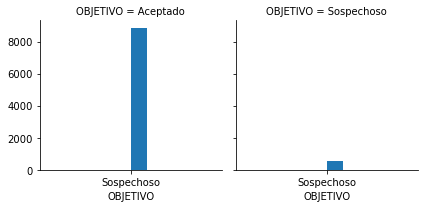

In [40]:
g = sns.FacetGrid(df[['OBJETIVO']], col='OBJETIVO')
g.map(plt.hist, 'OBJETIVO', bins=None,log=False)
df['OBJETIVO'].value_counts()

### EDA - Historical distribution to each classes

We will use a logarithmic representation to see the amount of samples for each feature, because with a normal representatión the diference between bands dificult the normal visibility behavior. <br>
Just looking directly the data we can see a behavior between classes, clearly the class 'Suspect' ranges between closer neighborhood, instead of a large neighborhood the we saw in the class 'Accepted'<br>
Another interesting thing that we can see is that all the features have a multiplier of 1e8 or 1e7,1e9, so we can easily scale the data and not have any changed over his distribution behavior.

* Proposal
    * Drop rows gentli over the class 'Aceptado', the amount of data allow us.
    * Fill the nan missing values
    * Escale the data normalizing data between 0 and 1
    * Make upsampling tho the class 'Sospechoso'

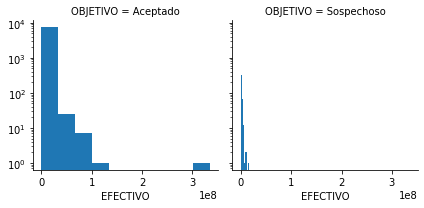

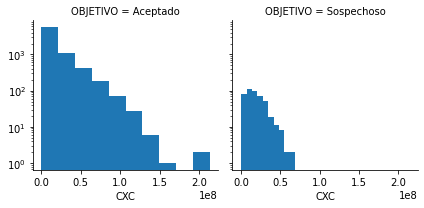

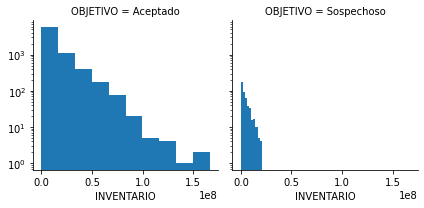

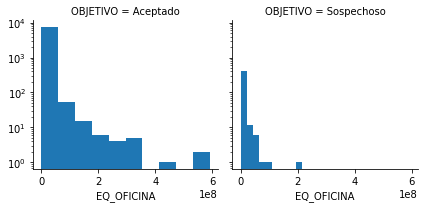

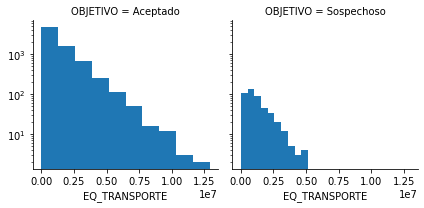

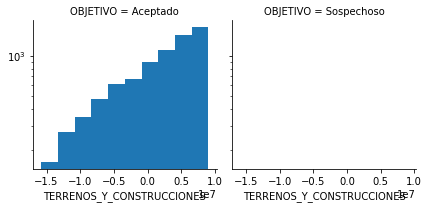

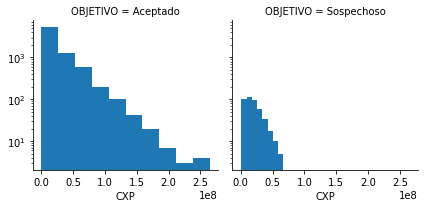

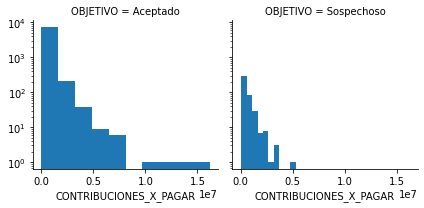

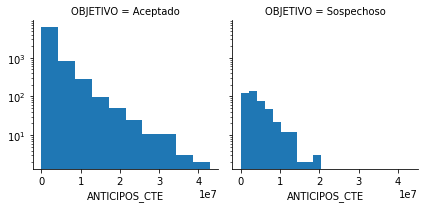

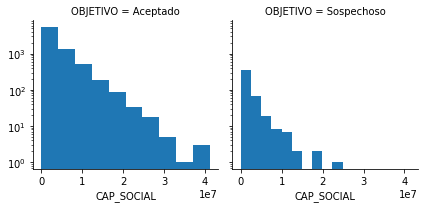

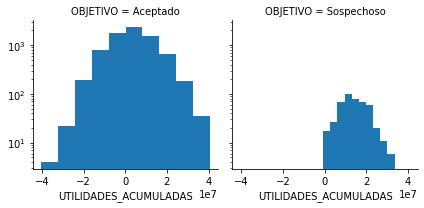

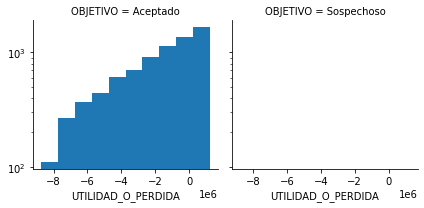

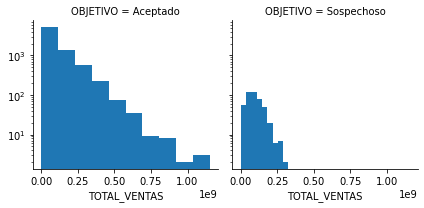

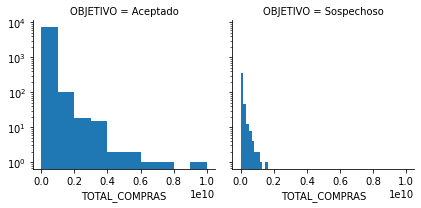

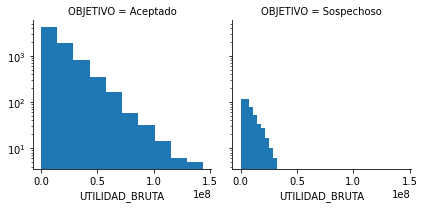

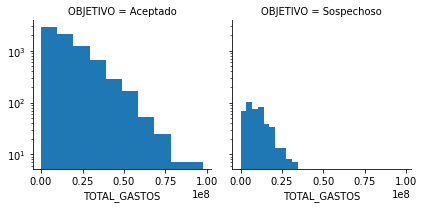

In [43]:
columns = df.columns.tolist()
columns.remove('OBJETIVO')
for column in columns:
    g = sns.FacetGrid(df[['OBJETIVO',column]], col='OBJETIVO')
    g.map(plt.hist, column, bins=None,log=True)

### EDA - Corretation Matrix of features
A simple and fast way to see the relationship between features is use a correlation matrix.<br>
We can see that son features have almost cero correlation with others, but not with the whole features.<br>
Every feature have a certein level of correlation with others feature.<br>
The amount of features equal to 16 could be an issue to our multi ensemble models using grid search because the limited technological sources.

* Proposal
    * Dimentionality reduction using PCA

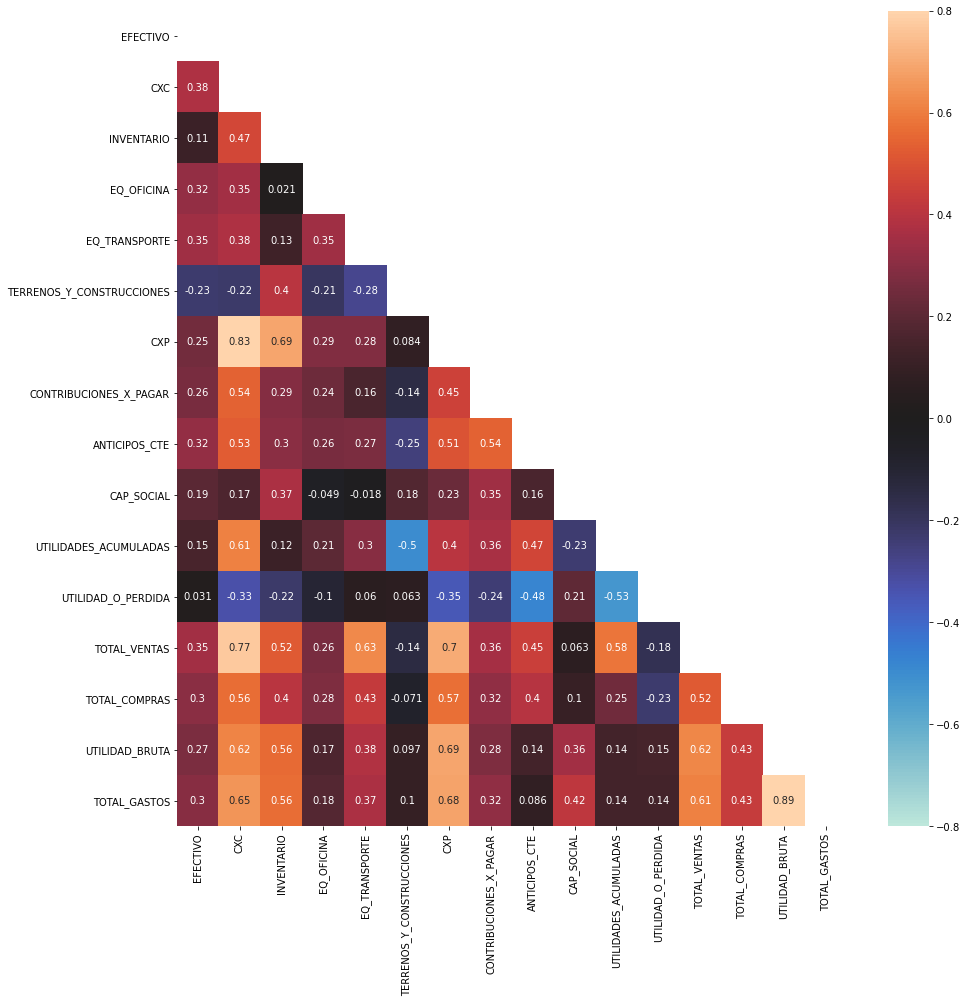

In [83]:
import seaborn as sns
# compute correlation matrix using pandas corr() function
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
corr_df = df_local.corr(method='pearson') 
matrix = np.triu(corr_df)
hmap=sns.heatmap(corr_df,annot=True, ax=ax, mask=matrix, vmin=-.8,vmax=.8, center=0)

# Feature Engineering

All the proposal were implemented in this section, I have created two classes to work with it.<br>
The first class called PreTrainData() was be used only for the train method.<br>
The second class called TransformData() was used for transform de data inside the pipeline




In [ ]:
### ONLY FOR PRETRAIN NOT PIPELINE
class PreTrainData( ):
    def __init__(self,target):
        self.target = target

    def fit(self, X, minNan2drop=5):
        # Guardando los valores medios
        
        #self.mean_glob = X.mean()
        df_temp_acep = X.loc[X[self.target ]=='Aceptado'].dropna(thresh=len(X.columns)-(minNan2drop-1))
        #self.mean_acep = df_temp_acep.mean()
        
        df_temp_sosp = X.loc[X[self.target ]=='Sospechoso']
        #self.mean_sosp = df_temp_sosp.mean()
        
        #df_temp_acep = df_temp_acep.fillna(self.mean_acep) 
        #df_temp_sosp = df_temp_sosp.fillna(self.mean_sosp) 
        df_temp = pd.concat([df_temp_acep,df_temp_sosp])
        
        y = X['OBJETIVO']
        df_temp = X.drop(columns = ['OBJETIVO'])
        columns = df_temp.columns.tolist()
        self.knnimputer = KNNImputer(n_neighbors=6, weights="uniform")
        self.knnimputer.fit(df_temp)
        df_temp = self.knnimputer.transform(df_temp)
        df_temp = pd.DataFrame(data=df_temp,columns = columns).join(y)
        
        
        count4bal = df_temp[self.target].value_counts().sort_values(ascending=True)
        class_minor = count4bal.index[0]
        class_mayor = count4bal.index[-1]
        mayority_sample = count4bal[-1]
        
        df_minority_upsampled = resample(df_temp.loc[df_temp[self.target]==class_minor], 
                                 replace=True,     # sample with replacement
                                 n_samples=mayority_sample,    # to match majority class
                                 random_state=17) # reproducible results
        
        df_temp = pd.concat([df_minority_upsampled,df_temp.loc[df_temp[self.target]==class_mayor]],ignore_index=True)
        #df_temp.reset_index(inplace=True)
        print(df_temp[self.target].value_counts())
        
        return df_temp


### Class for pipeline 

class TransformData(BaseEstimator, TransformerMixin):
    def __init__(self, n_components,target):
        self.n_components = n_components
        self.target = target

    def fit(self, X, y):
        # Guardando los valores medios
        #X = X.join(y)
        columns = X.columns.tolist()
        #self.mean_glob = X.mean()
        self.knnimputer = KNNImputer(n_neighbors=4, weights="uniform")
        self.knnimputer.fit(X)
        X = self.knnimputer.transform(X)
        
        X = pd.DataFrame(data=X,columns = columns).join(y)
        
        count4bal = X[self.target].value_counts().sort_values(ascending=True)
        class_minor = count4bal.index[0]
        class_mayor = count4bal.index[-1]
        mayority_sample = count4bal[-1]
        
        df_minority_upsampled = resample(X.loc[X[self.target]==class_minor], 
                                 replace=True,     # sample with replacement
                                 n_samples=mayority_sample,    # to match majority class
                                 random_state=17) # reproducible results
        
        df_temp = pd.concat([df_minority_upsampled,X.loc[X[self.target]==class_mayor]],ignore_index=True)
        
        self.scaler0 = MinMaxScaler()
        self.scaler0.fit(df_temp[columns])
        df_temp[columns] = self.scaler0.transform(df_temp[columns])
        
        df_balanced, label = df_temp.drop(columns=[self.target ]), df_temp[self.target ]
        self.pca = PCA(n_components=self.n_components)  # df_balanced, label
        self.scaler = MinMaxScaler()
        self.pca.fit(df_balanced) ## justa para todo el espectro de datos
        self.scaler.fit(self.pca.transform(df_balanced))
        return self
    
    
    def transform(self, X ):
        df_temp = self.knnimputer.transform(X) #X.fillna(self.mean_glob)
        df_temp = self.scaler0.transform(df_temp)

        df_transformed = self.pca.transform(df_temp)
        return self.scaler.transform(df_transformed)
    


### FE - Visualizing data after preprocess without scaling

Aceptado      8873
Sospechoso    8873
Name: OBJETIVO, dtype: int64
17746


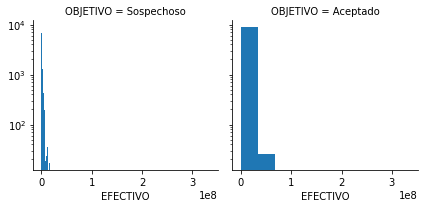

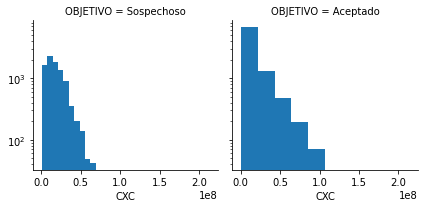

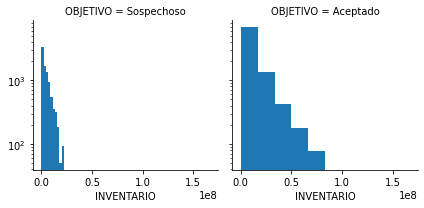

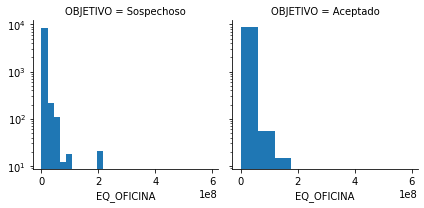

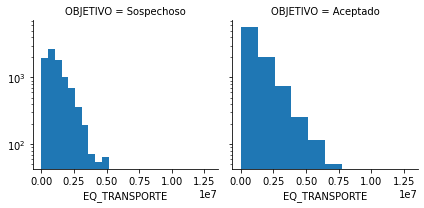

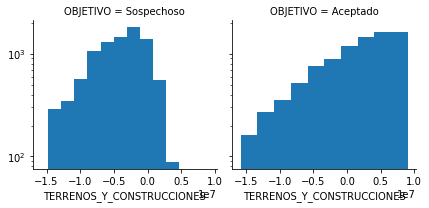

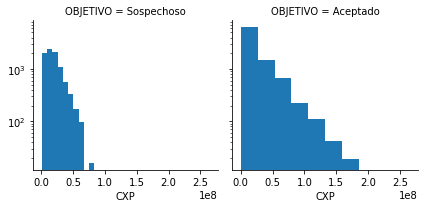

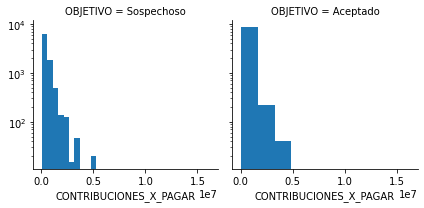

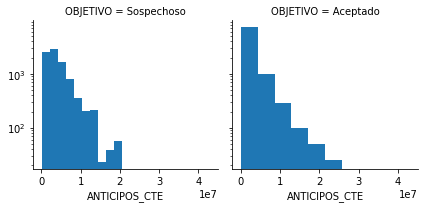

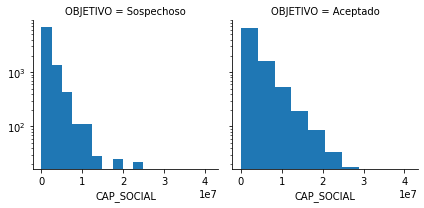

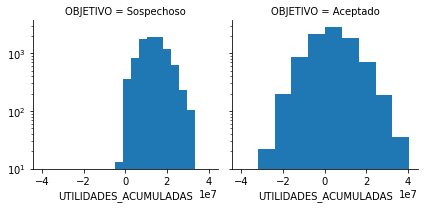

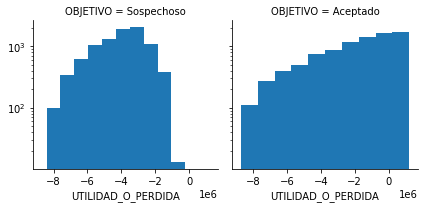

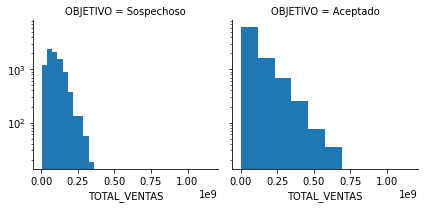

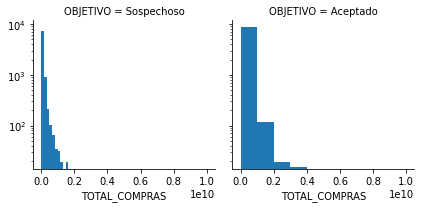

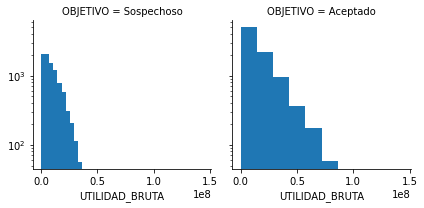

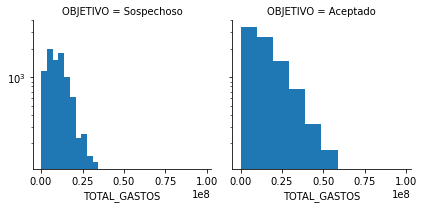

In [49]:
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)
print(len(df_local['OBJETIVO']))

columns = df_local.columns.tolist()
columns.remove('OBJETIVO')
for column in columns:
    g = sns.FacetGrid(df_local[['OBJETIVO',column]], col='OBJETIVO')
    g.map(plt.hist, column, bins=None,log=True)

### MODEL PREDICTIC TIME

In [13]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV,StratifiedKFold
#from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier#StackingClassifier
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import svm
from sklearn.decomposition import PCA
#from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from collections import defaultdict
from sklearn.metrics import classification_report

## Parameter optimization

In [16]:
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)
print(len(df_local['OBJETIVO']))

transformData = TransformData(n_components=10,target='OBJETIVO')
transformData.fit(df_local.drop(columns=['OBJETIVO']),df_local['OBJETIVO'])

X_train       = transformData.transform( df_local.drop(columns=['OBJETIVO']) ).copy()
y_train       = df_local['OBJETIVO'].copy()


skf = StratifiedKFold(n_splits=10)
cross_cal = []
# Parameters to tune
# SVC
tuned_parameters_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 'auto','scale'],'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel':['poly'], 'degree':[3,4,5,6,7]},
                     {'kernel':['sigmoid']}]
# XGB
tuned_parameters_xgb = [{'learning_rate':[0.01,0.001],'n_estimators':[5,40,60,70],'min_child_weight':[.05],'subsample':[.5,.4],'colsample_bytree':[0.5],
                    'objective':['binary:logistic'],'n_jobs':[-1] },
                    {'learning_rate':[0.02,0.005],'n_estimators':[5,20,40,70],'min_child_weight':[.01],'subsample':[.1,.2,.4],'colsample_bytree':[0.5],
                    'objective':['binary:logistic'],'n_jobs':[-1] }]
#KNC
tuned_parameters_knc = [{'n_neighbors':[2,4,6,8,10,12,20],'n_jobs':[-1],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'p':[1,2]}]

#RFC
tuned_parameters_rfc = [{'n_estimators':[10,40,50,80,100],'criterion':['gini','entropy'],'min_samples_split':[2,3,4,5],'n_jobs':[-1],'random_state':[15]}]

#GBC
tuned_parameters_gbc = [{'loss':['deviance','exponential'],'learning_rate':[0.1,0.001,0.2],'n_estimators':[20,80,120,150],'subsample':[1.0],'criterion':['friedman_mse', 'mse', 'mae'],'max_depth':[2,3,6,8,10],'random_state':[15]}]

#ETC
tuned_parameters_etc = [{ 'min_samples_split':[1.0,.2,.4,.8], 'n_estimators':[50,80,100,140,160],'warm_start':[True, False],'bootstrap':[True, False],
                         'n_jobs':[-1], 'random_state':[10,15], 'min_samples_leaf':[1,2,3,4] ,'criterion':['gini', 'entropy'],'max_features':[ 'sqrt','log2',None]   }]

# Parameter tunning
scores = ['f1']

# Best parameters
best_parameters = defaultdict(list)
models = { 'xgb': XGBClassifier(),'svc':svm.SVC(), 'rfc':RandomForestClassifier(), 'knc': KNC(),'gbc':GradientBoostingClassifier(),'etc':ExtraTreesClassifier() }
parameters = {'xgb': tuned_parameters_xgb, 'knc': tuned_parameters_knc,'rfc':tuned_parameters_rfc,'svc':tuned_parameters_svc, 'gbc':tuned_parameters_gbc, 'etc':tuned_parameters_etc }

#;ista = ['etc']
for model_name in models.keys():
    print("######### MODEL tunning hyper-parameters for %s" % model_name)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s" % (model_name, score))
        clf_i = GridSearchCV(models[model_name], parameters[model_name], scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters[model_name] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed classification report:")
        print()
        y_true, y_pred = y_train, clf_i.predict(X_train)
        print(classification_report(y_true, y_pred))

Aceptado      8873
Sospechoso    8873
Name: OBJETIVO, dtype: int64
17746
######### MODEL tunning hyper-parameters for xgb
# xgb - Tuning hyper-parameters for f1
Best parameters set found on development set:

{'colsample_bytree': 0.5, 'learning_rate': 0.02, 'min_child_weight': 0.01, 'n_estimators': 70, 'n_jobs': -1, 'objective': 'binary:logistic', 'subsample': 0.4}
Grid scores on development set:

Detailed classification report:

              precision    recall  f1-score   support

    Aceptado       1.00      0.93      0.96      8873
  Sospechoso       0.93      1.00      0.96      8873

    accuracy                           0.96     17746
   macro avg       0.96      0.96      0.96     17746
weighted avg       0.96      0.96      0.96     17746

######### MODEL tunning hyper-parameters for svc
# svc - Tuning hyper-parameters for f1


KeyboardInterrupt: 

## Best parameters

In [17]:
from collections import defaultdict
best_parameters = defaultdict(list,
            {'xgb': {'colsample_bytree': 0.5, 'learning_rate': 0.02, 'min_child_weight': 0.01, 'n_estimators': 70, 'n_jobs': -1, 'objective': 'binary:logistic', 'subsample': 0.4},
             'knc': {'algorithm': 'auto',
              'n_jobs': -1,
              'n_neighbors': 8,
              'p': 1},
             'rfc': {'criterion': 'entropy',
              'min_samples_split': 2,
              'n_estimators': 100,
              'n_jobs': -1},
             'svc': {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'},
             'gbc': {'criterion': 'mse',
              'learning_rate': 0.1,
              'loss': 'deviance',
              'max_depth': 3,
              'n_estimators': 150,
              'subsample': 1.0},
             'etc': {'bootstrap': True,
              'class_weight': 'balanced',
              'criterion': 'entropy',
              'max_features': 'auto',
              'min_samples_leaf': 3,
              'min_samples_split': 0.2,
              'n_estimators': 100,
              'n_jobs': -1,
              'random_state': 10,
              'warm_start': True}})

## Bagging Classifier MODEL - GRIDSEARCH + CV

In [18]:
clf_gbc = GradientBoostingClassifier(**best_parameters['gbc'] )#n_estimators=80, n_jobs=-1)# 20 - 80
clf_RFC = RandomForestClassifier(**best_parameters['rfc'] )#
clf_KNC = KNC(**best_parameters['knc'] )
xgb_model = XGBClassifier(**best_parameters['xgb'])
svc = svm.SVC(**best_parameters['svc'])
etc = ExtraTreesClassifier(**best_parameters['etc'])

models = { 'xgb': xgb_model,'svc':svc, 'rfc':clf_RFC, 'knc': clf_KNC,'gbc':clf_gbc,'etc':etc }

skf = StratifiedKFold(n_splits=5)
# Parameter tunning
scores = ['f1']
# Best parameters
best_parameters_bagging = defaultdict(list)
#lista = ['etc']
for model_name in models.keys():
    params_bagging = [{'n_estimators': [10,40,80,100,120], 'max_samples':[.5,.8,1.0],'base_estimator': [models[model_name]],'n_jobs':[-1] }]
    print("######### Bagging MODEL tunning hyper-parameters for %s" % model_name)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s" % (model_name, score))
        clf_i = GridSearchCV(BaggingClassifier(), params_bagging, scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters_bagging[model_name] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed Bagging classification report:")
        print()
        y_true, y_pred = y_train, clf_i.predict(X_train)
        print(classification_report(y_true, y_pred))

######### Bagging MODEL tunning hyper-parameters for xgb
# xgb - Tuning hyper-parameters for f1
Best parameters set found on development set:

{'base_estimator': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=None,
              min_child_weight=0.01, missing=nan, monotone_constraints=None,
              n_estimators=70, n_jobs=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.4, tree_method=None,
              validate_parameters=None, verbosity=None), 'max_samples': 1.0, 'n_estimators': 80, 'n_jobs': -1}
Grid scores on development set:

Detailed Bagging classification report:

              precision    recall  f1-score   support

    Aceptado       1.00    

### Loading Bagging Parameters

In [24]:
clf_gbc = GradientBoostingClassifier(**best_parameters['gbc'] )#n_estimators=80, n_jobs=-1)# 20 - 80
clf_RFC = RandomForestClassifier(**best_parameters['rfc'] )#
clf_KNC = KNC(**best_parameters['knc'] )
xgb_model = XGBClassifier(**best_parameters['xgb'])
svc = svm.SVC(**best_parameters['svc'])
etc = ExtraTreesClassifier(**best_parameters['etc'])

best_parameters_bagging = defaultdict(list,
            {'xgb': {'base_estimator': xgb_model,
              'max_samples': 1.0,
              'n_estimators': 80,
              'n_jobs': -1},
             'svc': {'base_estimator': svc,
              'max_samples': 1.0,
              'n_estimators': 40,
              'n_jobs': -1},
             'rfc': {'base_estimator': clf_RFC,
              'max_samples': 1.0,
              'n_estimators': 10,
              'n_jobs': -1},
             'knc': {'base_estimator': clf_KNC,
              'max_samples': 1.0,
              'n_estimators': 10,
              'n_jobs': -1},
             'gbc': {'base_estimator': clf_gbc,
              'max_samples': 0.8,
              'n_estimators': 10,
              'n_jobs': -1},
             'etc': {'base_estimator': etc,
              'max_samples': 1.0,
              'n_estimators': 100,
              'n_jobs': -1}})

## Voting Classifier Model

F1 Score for Voting model = 0.9771678685690524


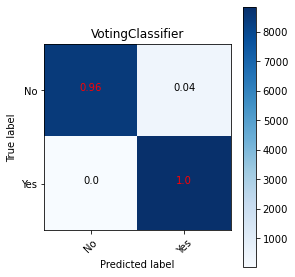

In [25]:
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score #( X_train_PCA , label)
from sklearn.metrics import f1_score
skf = StratifiedKFold(n_splits=5)

b_xgb_model=BaggingClassifier( **best_parameters_bagging['xgb'] )
b_clf_KNC  =BaggingClassifier( **best_parameters_bagging['knc'] )
b_clf_RFC  =BaggingClassifier( **best_parameters_bagging['rfc'] )
b_svc      =BaggingClassifier( **best_parameters_bagging['svc'] )
b_clf_gbc  =BaggingClassifier( **best_parameters_bagging['gbc'] )
b_etc      =BaggingClassifier( **best_parameters_bagging['etc'] )

best_parameters_vc = defaultdict(list)
weights = [1,1,1,1,1,1]


model_VC = VotingClassifier (estimators=[ ('xgb', b_xgb_model), ('knc', b_clf_KNC),('rfc',b_clf_RFC),('svc',b_svc),('gbc',b_clf_gbc),('etc',b_etc)], voting='hard', weights=weights,n_jobs=-1)
model_VC.fit(X_train,y_train)
y_pred = model_VC.predict(X_train)

print('F1 Score for Voting model = {}'.format(f1_score(y_train, y_pred, average='macro')))
plot_confusion_matrix(y_true=y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="VotingClassifier",normalize=True,size=4)


<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    pipeline_target,
    test_size=0.8,
    random_state=27,
    stratify=pipeline_target,
)

#df_local = pd.concat([df_temp_acep,df_temp_sosp])
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)


transformData = TransformData(n_components=10,target='OBJETIVO')
############### PIPELINE
my_pipeline = Pipeline(
    steps=[
        ('preproces_transform', transformData),

        ('modelo_BaggingClassfier', model_VC),
    ]
)

my_pipeline.fit(df_local.drop(columns=['OBJETIVO']),df_local['OBJETIVO'])


Aceptado      8873
Sospechoso    8873
Name: OBJETIVO, dtype: int64


Pipeline(steps=[('preproces_transform',
                 TransformData(n_components=10, target='OBJETIVO')),
                ('modelo_BaggingClassfier',
                 VotingClassifier(estimators=[('xgb',
                                               BaggingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                                                              booster=None,
                                                                                              colsample_bylevel=None,
                                                                                              colsample_bynode=None,
                                                                                              colsample_bytree=0.5,
                                                                                              gamma=None,
                                                                                              gpu_id=None,
          

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.976\nPrecision=0.957\nRecall=0.997\nF1 Score=0.976')

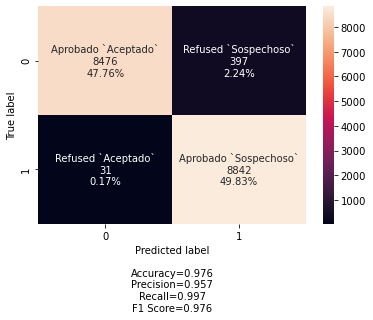

In [28]:
from sklearn.metrics import confusion_matrix

y_pred = my_pipeline.predict(df_local.drop(columns=['OBJETIVO']))
cf_matrix = confusion_matrix(df_local['OBJETIVO'], y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente conjunto de datos llamado "to_be_scored_compusoluciones.csv":

### Descarga la "hoja de evaluación"

In [16]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()

--2020-09-04 18:16:18--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: 'to_be_scored_compusoluciones.csv'

     0K .......... .......... .......... .......... .......... 51%  320K 0s
    50K .......... .......... .......... .......... .......   100%  726K=0.2s

2020-09-04 18:16:19 (440 KB/s) - 'to_be_scored_compusoluciones.csv' saved [100124/100124]



,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,103003.8264,2402813.337,NaN,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,NaN,1.858752e+06
596,8.806031e+05,3.354813e+07,NaN,5.241604e+06,NaN,-1.727618e+06,4.021914e+07,821297.6732,3154291.078,NaN,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07
597,NaN,2.711050e+07,3.260820e+06,4.681080e+06,NaN,-3.291876e+06,3.763157e+07,NaN,1861471.266,942635.7885,7.126997e+06,NaN,6.531900e+07,1.014415e+08,2.333685e+07,NaN
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,NaN,5220998.681,NaN,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,NaN,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06


# ¡Atención!

El Dataframe ``to_be_scored_compusoluciones`` es su "hoja de evaluación". Tenga en cuenta que a la columna "OBJETIVO" le faltan datos en este ejemplo, que luego no se pueden usar para entrenar modelos de aprendizaje supervisado.

In [17]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
EFECTIVO                     511 non-null float64
CXC                          511 non-null float64
INVENTARIO                   511 non-null float64
EQ_OFICINA                   505 non-null float64
EQ_TRANSPORTE                513 non-null float64
TERRENOS_Y_CONSTRUCCIONES    513 non-null float64
CXP                          523 non-null float64
CONTRIBUCIONES_X_PAGAR       499 non-null float64
ANTICIPOS_CTE                515 non-null float64
CAP_SOCIAL                   504 non-null float64
UTILIDADES_ACUMULADAS        496 non-null float64
UTILIDAD_O_PERDIDA           514 non-null float64
TOTAL_VENTAS                 506 non-null float64
TOTAL_COMPRAS                527 non-null float64
UTILIDAD_BRUTA               501 non-null float64
TOTAL_GASTOS                 510 non-null float64
dtypes: float64(16)
memory usage: 75.1 KB


<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 600 entradas, con los valores calculados en la columna "target"

<hr>

In [18]:
# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df_to_be_scored)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df_to_be_scored_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_to_be_scored
    ),
)

# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df_to_be_scored_2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df_to_be_scored_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_to_be_scored_2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df_to_be_scored_2.columns  # las columnas originales deben conservarse en esta transformación
)

In [19]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(df_to_be_scored_3)

In [21]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

,EFECTIVO,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,target
595,3.893725e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,103003.8264,2402813.337,0.0000,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,0.000000e+00,1.858752e+06,Sospechoso
596,8.806031e+05,0.000000e+00,5.241604e+06,0.000000e+00,-1.727618e+06,821297.6732,3154291.078,0.0000,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07,Sospechoso
597,0.000000e+00,3.260820e+06,4.681080e+06,0.000000e+00,-3.291876e+06,0.0000,1861471.266,942635.7885,7.126997e+06,0.000,6.531900e+07,1.014415e+08,2.333685e+07,0.000000e+00,Aceptado
598,7.443979e+06,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,0.0000,5220998.681,0.0000,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07,Sospechoso
599,5.611681e+05,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06,Sospechoso


### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [23]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

AttributeError: 'DataFrame' object has no attribute 'save_data'

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones! 

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://compusoluciones.maratona.dev